<a href="https://colab.research.google.com/github/H0wAreU/Statistical-Learning-Labs./blob/main/Lab05_decision_tree_bagging_RF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Statistical Learning for Data Science 2 (229352)
#### Instructor: Donlapark Ponnoprat

#### [Course website](https://donlapark.pages.dev/229352/)

## Lab #5

#### Load data at: https://donlapark.pages.dev/229352/heart_disease.csv

* Decision tree ([documentation](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html))
* Random hyperparameter search using cross-validation ([documentation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html))

In [ ]:
import pandas as pd
import graphviz

from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier

# import data
data = pd.read_csv("heart_disease.csv", na_values="?")
data.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,label
0,63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,1
2,67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
3,37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0,0


In [ ]:

# split into X and y
y = data["label"]
X = data.drop("label", axis=1)

# split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y)

# impute missing values
imputer = SimpleImputer(strategy="mean")
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

# Create a decision tree
clf = DecisionTreeClassifier()

![5CV](https://scikit-learn.org/stable/_images/grid_search_cross_validation.png)

In [ ]:
params = {'max_depth': [3, 6, 9, 12]}

gridcv = GridSearchCV(clf, params, scoring='accuracy', cv=5)
gridcv.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': [3, 6, 9, 12]}, scoring='accuracy')

In [ ]:
gridcv.best_estimator_

DecisionTreeClassifier(max_depth=3)

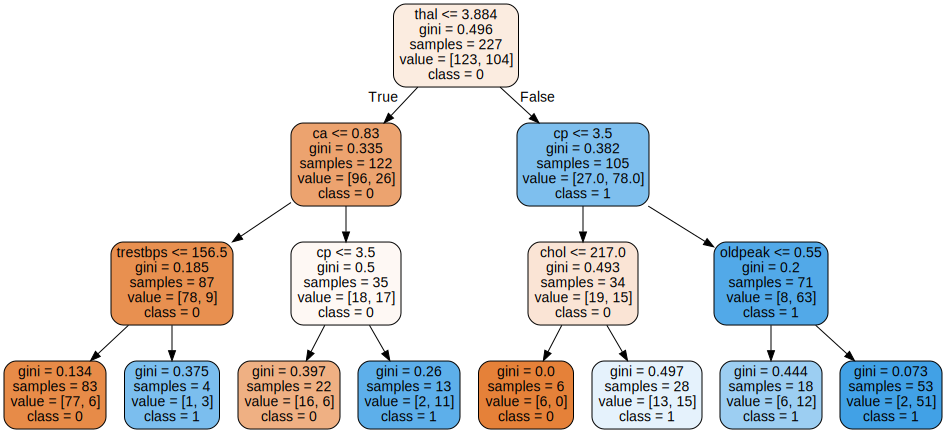

In [ ]:
plot_data = export_graphviz(gridcv.best_estimator_,
                            out_file=None,
                            filled=True,
                            rounded=True,
                            feature_names=data.columns[:-1],
                            class_names=['0', '1'])

graph = graphviz.Source(plot_data)
graph

## Bagged decision trees
* Bagging classifier ([documentation](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html))

In [ ]:
from sklearn.metrics import classification_report

clf = DecisionTreeClassifier()
bagged_trees = BaggingClassifier(clf, n_estimators=100,max_samples=X_train.shape[0],max_features=5)
bagged_trees.fit(X_train, y_train)

ypred = bagged_trees.predict(X_test)
print(classification_report(y_test, ypred))

              precision    recall  f1-score   support

           0       0.83      0.93      0.87        41
           1       0.90      0.77      0.83        35

    accuracy                           0.86        76
   macro avg       0.86      0.85      0.85        76
weighted avg       0.86      0.86      0.85        76



## Random forest classifier
* Random forest ([documentation](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html))

In [ ]:
rf = RandomForestClassifier(n_estimators=200)

rf.fit(X_train, y_train)

ypred = rf.predict(X_test)
print(classification_report(y_test, ypred))

              precision    recall  f1-score   support

           0       0.84      0.93      0.88        41
           1       0.90      0.80      0.85        35

    accuracy                           0.87        76
   macro avg       0.87      0.86      0.87        76
weighted avg       0.87      0.87      0.87        76



#### Exercise
1. Study the hyperparameters of three models: [Decision tree](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html), [Bagged Decision Trees](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html) and [Random Forest](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)
2. For each model, use pipeline+grid search cross-validation across multiple hyperparameters to find the best model.
* Decision tree: choose at least 3 hyperparameters
* Bagged decision trees: choose at least 3 hyperparameters
* Random forest: choose at least 3 hyperparameters
3. For each model, compute the `f1_macro` and `accuracy` score on the test set.
* What is your best model?
* Plot the best tree model
* What hyperparameters did you choose? (explain in words, not in `sklearn's` parameter name)
* What are the best values of your hyperparameters?

In [ ]:
def run_grid_search(name, pipeline, param_grid):
    grid = GridSearchCV(pipeline, param_grid, cv=5, scoring=['accuracy','f1_macro'], refit='accuracy')
    grid.fit(X_train, y_train)
    print(f"--- {name} ---")
    print(f"Best Score: {grid.best_score_:.4f}")
    print(f"Best Params: {grid.best_params_}\n")
    return grid

In [ ]:
pipe_dt = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', DecisionTreeClassifier(random_state=42))
])

param_grid_dt = {
    'clf__max_depth': [None, 5, 10, 20],
    'clf__min_samples_split': [2, 5, 10],
    'clf__criterion': ['gini', 'entropy']
}

grid_dt = run_grid_search("Decision Tree", pipe_dt, param_grid_dt)

--- Decision Tree ---
Best Score: 0.7310
Best Params: {'clf__criterion': 'gini', 'clf__max_depth': None, 'clf__min_samples_split': 2}



In [ ]:
pipe_bag = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', BaggingClassifier(estimator=DecisionTreeClassifier(), random_state=42))
])

param_grid_bag = {
    'clf__n_estimators': [10, 50, 100],
    'clf__max_samples': [0.5, 0.8, 1.0],
    'clf__max_features': [0.5, 0.8, 1.0]
}

grid_bag = run_grid_search("Bagged Decision Trees", pipe_bag, param_grid_bag)

--- Bagged Decision Trees ---
Best Score: 0.8014
Best Params: {'clf__max_features': 0.8, 'clf__max_samples': 0.8, 'clf__n_estimators': 50}



In [ ]:
pipe_rf = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', RandomForestClassifier(random_state=42))
])

param_grid_rf = {
    'clf__n_estimators': [50, 100, 200],
    'clf__max_features': ['sqrt', 'log2', None],
    'clf__min_samples_leaf': [1, 2, 4]
}

grid_rf = run_grid_search("Random Forest", pipe_rf, param_grid_rf)

--- Random Forest ---
Best Score: 0.8058
Best Params: {'clf__max_features': 'sqrt', 'clf__min_samples_leaf': 4, 'clf__n_estimators': 200}



In [ ]:
from sklearn.metrics import accuracy_score, f1_score, classification_report
import matplotlib.pyplot as plt
from sklearn import tree

# สมมติว่าเรารัน GridSearchCV มาแล้ว 3 ตัว: grid_dt, grid_bag, grid_rf
models = {
    "Decision Tree": grid_dt,
    "Bagged Trees": grid_bag,
    "Random Forest": grid_rf
}

results = {}

for name, model in models.items():
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='macro')
    results[name] = {'Accuracy': acc, 'F1_Macro': f1, 'Object': model}

    print(f"[{name}] Accuracy: {acc:.4f}, F1 Macro: {f1:.4f}")

# หาโมเดลที่ดีที่สุด (ตัดสินจาก F1 Macro)
best_model_name = max(results, key=lambda x: results[x]['F1_Macro'])
print(f"\n Best Model: {best_model_name}")

[Decision Tree] Accuracy: 0.7368, F1 Macro: 0.7276
[Bagged Trees] Accuracy: 0.8026, F1 Macro: 0.7984
[Random Forest] Accuracy: 0.8816, F1 Macro: 0.8799

 Best Model: Random Forest


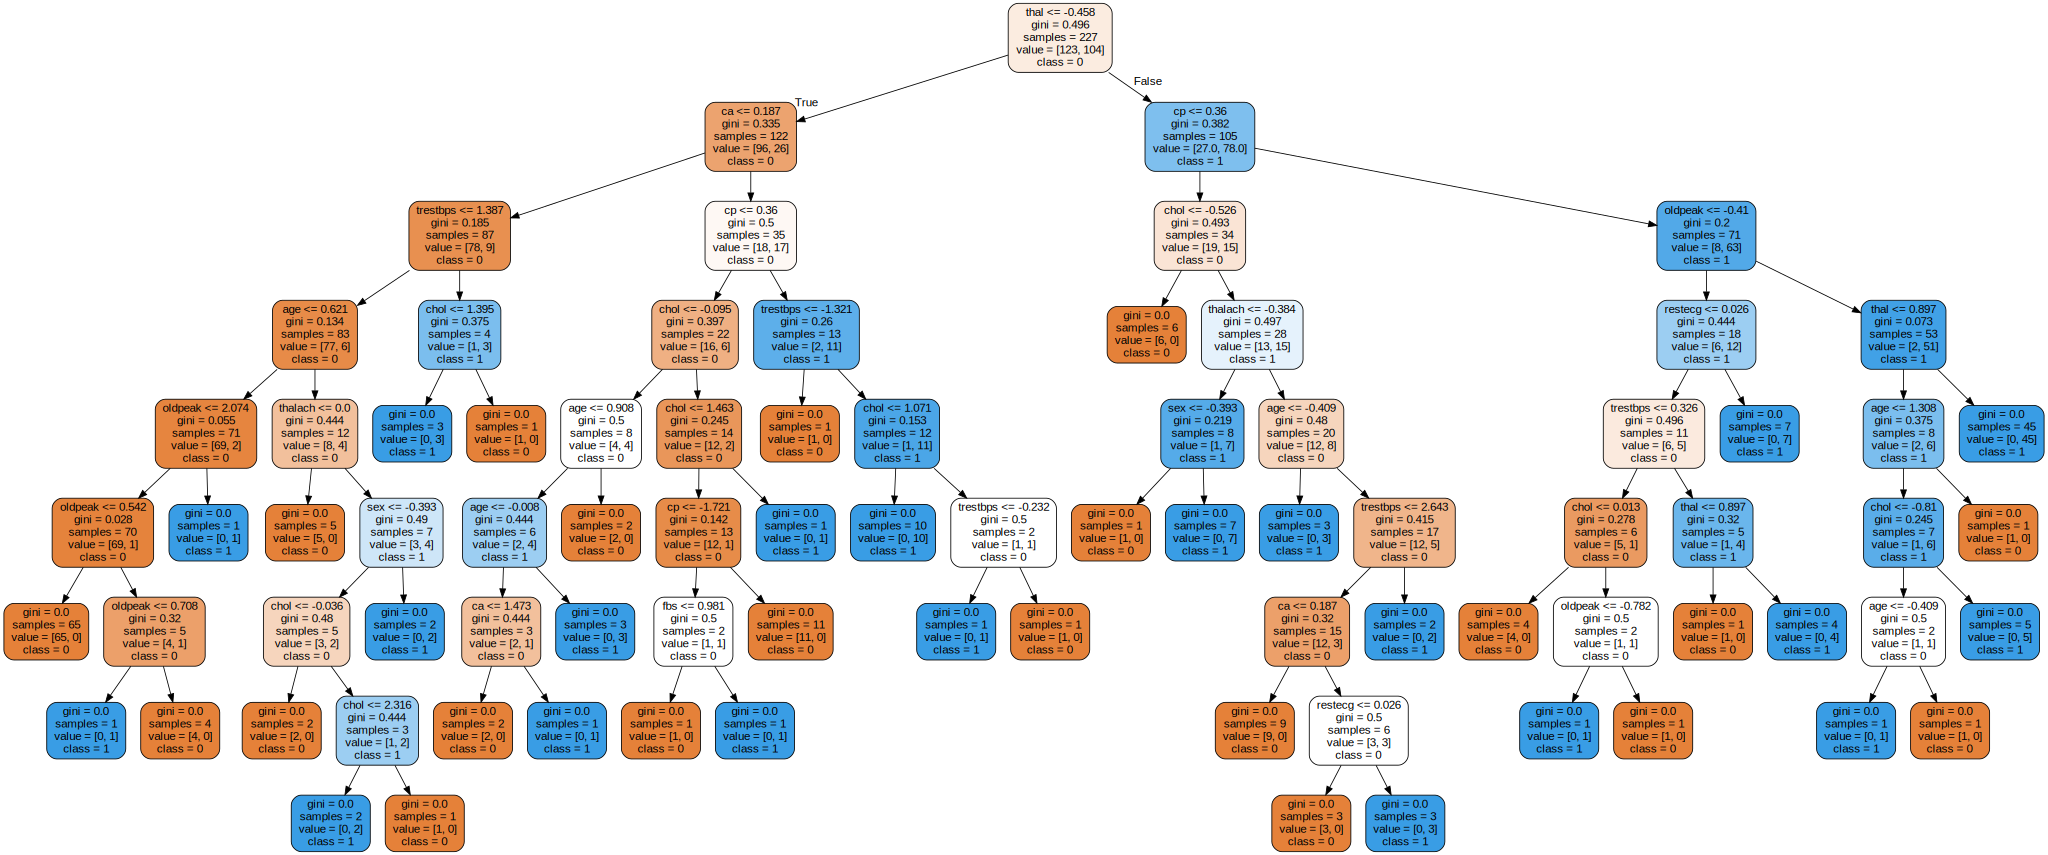

In [54]:
import graphviz
from sklearn.tree import export_graphviz

# Get the best Decision Tree estimator from the pipeline
best_dt_model = grid_dt.best_estimator_.named_steps['clf']

# Visualize the best Decision Tree
plot_data = export_graphviz(best_dt_model,
                            out_file=None,
                            filled=True,
                            rounded=True,
                            feature_names=data.columns[:-1], # X column names
                            class_names=['0', '1'])

graph = graphviz.Source(plot_data)
graph

#What hyperparameters did you choose?
n_estimators': [50, 100, 200] , max_features': ['sqrt', 'log2', None]
,min_samples_leaf': [1, 2, 4] เป็น hyperparameters ของ randomforest

In [56]:
param_grid_rf = {
    'clf__n_estimators': [50, 100, 200],
    'clf__max_features': ['sqrt', 'log2', None],
    'clf__min_samples_leaf': [1, 2, 4]
}
gridcv = GridSearchCV(pipe_rf, param_grid_rf, scoring='accuracy', cv=5)
gridcv.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('clf',
                                        RandomForestClassifier(random_state=42))]),
             param_grid={'clf__max_features': ['sqrt', 'log2', None],
                         'clf__min_samples_leaf': [1, 2, 4],
                         'clf__n_estimators': [50, 100, 200]},
             scoring='accuracy')

# What are the best values of your hyperparameters?
min_samples_leaf=4, n_estimators=200, random_state=42